In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
#warnings.filterwarnings("ignore", message="Glyph.*missing from font")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)


### Step 1: Task and environment generation

## 🔍 Parameter Mapping: Findling et al. (2021) Paper ↔ Code

### VarVol (Varying-Volatility) Model Parameters

| Paper Symbol | Paper Name | Code Variable | Prior/Range | Type |
|--------------|------------|---------------|-------------|------|
| **η** | Feedback noise | `beta_samples/2 + 0.5` | η/2 ~ Beta(1,1) → η ∈ [0.5,1] | Latent parameter |
| **ν** | Volatility variance | `nu_samples` | Inv-Gamma(3, 0.001) | Latent parameter |
| **γ** | Task-set probabilities | `gamma_samples` | Dirichlet(1,...,1) | Latent parameter |
| **τ** | Volatility (switch prob) | `tau_particles` | Bounded RW in [0, 0.5] | Latent state |
| **z** | Task-set | `state_particles` | Discrete {0,...,K-1} | Latent state |
| **β** (softmax) | Inverse temperature | `beta_softmax` | Free param, fit via MLE | **FREE PARAMETER** |

### Weber-Imprecision Model Parameters

| Paper Symbol | Paper Name | Code Variable | Prior/Default | Type |
|--------------|------------|---------------|---------------|------|
| **η** | Feedback noise | `beta_samples/2 + 0.5` | η/2 ~ Beta(1,1) → η ∈ [0.5,1] | Latent parameter |
| **γ** | Task-set probabilities | `gamma_samples` | Dirichlet(1,...,1) | Latent parameter |
| **z** | Task-set | `state_particles` | Discrete {0,...,K-1} | Latent state |
| **λ** | Weber scaling | `lambdaa` | Default: 0.9 | **FREE PARAMETER** |
| **μ** | Weber baseline | `mu` | Default: 0.0 | **FREE PARAMETER** |
| **β** (softmax) | Inverse temperature | `beta_softmax` | Free param, fit via MLE | **FREE PARAMETER** |

---

## 📊 Understanding the Experimental Setup

### Q1: How are trials constructed?
We use **EXACT trial-by-trial data** from the human experiment:
- `hidden_state`: Which arm was correct on each trial (0 or 1)
- `false_feedback`: Whether feedback was flipped (trap) on each trial
- `outcome`: The **actual reward** the human received ("win" or "loss")
- `userChoice`: What the human actually chose

**CRITICAL**: The agent observes the same rewards the human saw, not re-computed rewards!

### Q2: What is the MLE fitting doing?
For each participant:
1. Agent sees stimulus → predicts P(action)
2. We compute: how likely was the **human's actual choice** under this model?
3. Optimizer adjusts parameters (β for VarVol; β, λ, μ for Weber) to maximize this likelihood
4. Agent observes the **same reward the human saw** (not what's "correct")

**The model is NOT trying to predict the correct action - it's trying to predict what the HUMAN did!**

### Q3: What is "task accuracy" then?
- **Human accuracy**: % of human choices that matched the correct arm
- **Model accuracy**: % of model's choices that match the correct arm (this is a secondary metric)
- **Match rate**: % of model's choices that match what the human did (THIS is what we optimize!)

### Q4: Particle counts - What did Findling use?
| Setting | Exact models | Forward models (we use this) |
|---------|--------------|------------------------------|
| θ particles | 1,000 | 200 |
| State particles | 1,000 | 200 |
| Total | **1,000,000** | **40,000** |

For a seminar project, **100×100 = 10K particles** is reasonable for speed. **200×200 = 40K** matches the paper's forward approximation.

---

## 🎯 Beta Softmax Explained (with example!)

The softmax converts beliefs into action probabilities using **log-beliefs**:

$$P(a) \propto \exp(\beta \cdot \log(\text{belief}_a)) = \text{belief}_a^\beta$$

### Example: Beliefs = [0.6, 0.4]

| β (inverse temp) | P(action=0) | P(action=1) | Behavior |
|------------------|-------------|-------------|----------|
| β = 0.5 | $0.6^{0.5}/(0.6^{0.5}+0.4^{0.5}) = 0.55$ | 0.45 | Very soft/random |
| **β = 1.0** | $0.6/1.0 = 0.60$ | 0.40 | Proportional to beliefs |
| β = 2.0 | $0.36/(0.36+0.16) = 0.69$ | 0.31 | More deterministic |
| **β = 4.0** | $0.1296/(0.1296+0.0256) = 0.84$ | 0.16 | Quite deterministic |
| β = 10.0 | ~0.97 | ~0.03 | Nearly argmax |
| β → ∞ | 1.0 | 0.0 | Pure argmax |

**Higher β = more deterministic choices based on beliefs!**

---

## ⚠️ About Noise Blocks

Your experiment has blocks with different noise levels (high/medium). The models handle this because:

1. **The agent learns from feedback** - if feedback is noisier, the agent's belief updates will be noisier
2. **η (feedback noise)** is a **latent parameter** that the agent INFERS from the data
3. The agent doesn't know the block structure - it just observes stimulus-action-reward and adapts

**This is fine!** The agent will naturally track that feedback became more/less reliable.

In [43]:
@dataclass
class VolatileBanditTask:
    """Container that stores a whole task instance for re-use across agents."""
    stimuli: np.ndarray  # here it is always zero but kept for completeness
    latent_states: np.ndarray  # z_t, the true task-set index
    switch_prob: np.ndarray  # τ_t
    traps: np.ndarray  # Bernoulli noise on rewards
    correct_actions: np.ndarray  # action that yields positive feedback if there is no trap
    beta: float  # feedback reliability parameter η in the paper


def generate_bandit_task(
    trial_num: int = 200,
    tau_min: float = 0.0,    # Paper: τ ∈ [0, 0.5]
    tau_max: float = 0.5,    # Paper: τ ∈ [0, 0.5]
    nu: float = 1e-4,        # Constant within a block; model infers it via Inv-Gamma(3, 0.001) prior
    beta: float = 0.9,       # η (feedback reliability); model infers via η/2 ~ Beta(1,1) → η ∈ [0.5,1]
    seed: Optional[int] = None,
) -> VolatileBanditTask:
    """Generate a single task trajectory following Findling et al. (2021) Methods.

    Paper specification:
    - τ_t varies as bounded Gaussian random walk in [0, 0.5] with variance ν
    - ν is constant within a block (model has Inv-Gamma(3, 0.001) prior)
    - When z_t changes, new state drawn from Dirichlet(1,...,1) excluding previous
    - Feedback: r_t ~ Bernoulli(η) if correct, Bernoulli(1-η) if incorrect

    Parameters
    ----------
    trial_num : int
        Number of interaction steps.
    tau_min, tau_max : float
        Lower/upper bounds for volatility τ. Paper uses [0, 0.5].
    nu : float
        Variance of the Gaussian random walk on τ. Constant within block.
    beta : float
        Feedback reliability η. Paper: η > 0.5, prior is η/2 ~ Beta(1,1).
    seed : int, optional
        RNG seed for reproducibility.
    """
    rng = np.random.default_rng(seed)
    stimuli = np.zeros(trial_num, dtype=int)  # one stimulus, two actions

    tau = np.zeros(trial_num)
    tau[0] = tau_min
    for t in range(1, trial_num):
        tau[t] = np.clip(rng.normal(tau[t - 1], np.sqrt(nu)), tau_min, tau_max)

    latent = np.zeros(trial_num, dtype=int)
    latent[0] = rng.integers(2)
    traps = rng.random(trial_num) > beta  # True = reward flips

    for t in range(1, trial_num):
        if rng.random() < tau[t]:
            latent[t] = 1 - latent[t - 1]  # with K=2, switching means flipping
        else:
            latent[t] = latent[t - 1]

    correct_actions = latent.copy()  # mapping is identity in the closed 2-armed case

    return VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent,
        switch_prob=tau,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )


# def generate_stable_volatility_task(
#     trial_num: int = 200,
#     tau: float = 0.05,           # Fixed 5% volatility (stable)
#     beta: float = 0.9,           # Feedback reliability η
#     seed: Optional[int] = None,
# ) -> VolatileBanditTask:
#     """
#     🎰 2-ARMED BANDIT with STABLE (fixed) volatility.
    
#     Unlike generate_bandit_task where τ varies via random walk, here:
#     - Volatility τ is CONSTANT (fixed probability of switch each trial)
#     - Feedback noise η (beta) varies between conditions:
#       * Low noise:  η = 0.9 (90% reliable feedback)
#       * High noise: η = 0.7 (70% reliable feedback)
    
#     This setup isolates the effect of NOISE while keeping volatility stable.
    
#     Parameters
#     ----------
#     trial_num : int
#         Number of trials.
#     tau : float
#         Fixed switch probability. Default 0.05 (5%).
#     beta : float
#         Feedback reliability η. 
#         - Low noise condition: β = 0.9
#         - High noise condition: β = 0.7
#     seed : int, optional
#         RNG seed for reproducibility.
#     """
#     rng = np.random.default_rng(seed)
    
#     stimuli = np.zeros(trial_num, dtype=int)  # single stimulus
    
#     # Constant volatility (no random walk!)
#     tau_array = np.full(trial_num, tau)
    
#     # Generate latent states with fixed switch probability
#     latent = np.zeros(trial_num, dtype=int)
#     latent[0] = rng.integers(2)
    
#     for t in range(1, trial_num):
#         if rng.random() < tau:
#             latent[t] = 1 - latent[t - 1]  # switch
#         else:
#             latent[t] = latent[t - 1]      # stay
    
#     # Feedback noise (traps)
#     traps = rng.random(trial_num) > beta
    
#     correct_actions = latent.copy()
    
#     return VolatileBanditTask(
#         stimuli=stimuli,
#         latent_states=latent,
#         switch_prob=tau_array,
#         traps=traps,
#         correct_actions=correct_actions,
#         beta=beta,
#     )


In [44]:
class TwoArmedBanditEnv:
    """Minimal environment that feeds the agents with stimuli and rewards."""

    def __init__(self, task: VolatileBanditTask):
        self.task = task
        self.index = 0

    def reset(self):
        self.index = 0

    def step(self, action: int) -> Tuple[int, int, int]:
        """Play one trial and return (stimulus, reward, correct_action)."""
        stimulus = self.task.stimuli[self.index]
        correct_action = self.task.correct_actions[self.index]
        trap = self.task.traps[self.index]

        if action == correct_action:
            reward = int(not trap)
        else:
            reward = int(trap)

        self.index += 1
        return stimulus, reward, correct_action


### Step 2: Particle filtering utilities - the sequential Monte Carlo (SMC) algorithm
*Reminder: a particle = a hypothesis about a parameter, weighted by how probable it is given observations*

The forward models in the repo maintain two layers of particles:

1. **State particles** encode beliefs over latent task-sets `z_t` and, for the varying-volatility agent, the latent hazard `τ_t`.
2. **Parameter particles** encode beliefs over the hyper-parameters `(β, ν, γ)` (varying volatility) or `(β, γ)` (Weber).

We reproduce the exact helper routines (stratified resampling, inverse-gamma sampling, etc.) here to keep the notebook self-contained.


In [45]:
# ============================================================
# GLOBAL CONSTANTS (required by agent classes)
# ============================================================
K = 2  # Number of task-sets (latent states) in closed 2-armed bandit

# TASK_MAPPING[stimulus] returns array of correct actions for each task-set
# For closed environment: stimulus 0, task-set 0 -> action 0, task-set 1 -> action 1
TASK_MAPPING = np.array([[0, 1]])  # Shape: (n_stimuli, K) = (1, 2)

def stratified_resample(weights: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """Stratified resampling as used in the original C++ code."""
    n = len(weights)
    cumulative = np.cumsum(weights)
    positions = (rng.random(n) + np.arange(n)) / n
    return np.searchsorted(cumulative, positions)


def sample_inv_gamma(shape: float, scale: float, size: int, rng: np.random.Generator) -> np.ndarray:
    """Inverse-gamma sampler matching utils/useful_functions.py."""
    return scale / rng.gamma(shape, size=size)


def logsumexp(log_w: np.ndarray) -> float:
    b = np.max(log_w)
    return b + np.log(np.sum(np.exp(log_w - b)))


def normalise_log_weights(log_w: np.ndarray) -> np.ndarray:
    """Convert log-weights to normalized weights without numerical trouble."""
    log_w = log_w - logsumexp(log_w)
    return np.exp(log_w)


def compute_positive_states(mapping: np.ndarray, stimulus: int, action: int, reward: int) -> np.ndarray:
    """Replicates isEqual_and_adapted_logical_xor from the C++ helpers."""
    equals = mapping[stimulus] == action
    if reward:  # reward==1 means the action was *reported* as correct
        return equals.astype(float)
    return (~equals).astype(float)


def sample_new_state_excluding(current: int, gamma: np.ndarray, rng: np.random.Generator) -> int:
    probs = gamma.copy()
    probs[current] = 0.0
    total = probs.sum()
    if total == 0:
        probs[:] = 1.0 / len(probs)
    else:
        probs /= total
    return rng.choice(len(probs), p=probs)



### Step 3a: Forward varying-volatility agent
This class mirrors `simulation_functions/varvol_forward/SMC2.py` and `lib_c/varvol_forward/SMCfunctions.cpp`:
- Each *theta* particle samples `(β, ν, γ)`.
- Each theta carries `number_of_state_particles` state trajectories that track both latent task-set `z` and latent hazard `τ`.
- After every observation we:
  1. **Update weights** using the Bernoulli feedback likelihood.
  2. **Resample** state trajectories within each theta according to those weights.
  3. **Propagate** the trajectories by sampling a new `τ` and, with probability `τ`, switching to a different task-set drawn from `γ`.
  4. **Adapt** the parameter particles if the effective sample size (ESS) collapses.

The result is a biologically plausible online approximation of the exact SMC² solution.


In [46]:
class ForwardVaryingVolatilityAgent:
    """Forward (online) SMC approximation of the exact varying-volatility model.
    
    Parameters (Paper vs Code mapping):
    ------------------------------------
    LATENT PARAMETERS (inferred by SMC):
    - beta_samples (internal): η/2 sampled from Beta(1,1), transformed to η = beta/2 + 0.5
      This is the FEEDBACK NOISE parameter (η > 0.5 in paper)
    - nu_samples (internal): ν sampled from Inv-Gamma(3, 0.001)
      This is the VOLATILITY VARIANCE parameter
    - gamma_samples (internal): γ sampled from Dirichlet(1,...,1)
      These are the task-set COMBINATION PROBABILITIES
    
    LATENT STATES (tracked by particle filter):
    - state_particles: z_t, the current task-set hypothesis
    - tau_particles: τ_t, the current volatility (switch probability)
    
    FREE PARAMETERS (for model fitting):
    - beta_softmax: β, the softmax inverse temperature
      NOTE: This is DIFFERENT from beta_samples (feedback noise η)!
      When None, uses argmax policy (deterministic).
    - epsilon_softmax: Lapse rate for random exploration
    """

    def __init__(
        self,
        num_theta: int = 400, 
        num_state_particles: int = 200,
        tau_default: float = 0.03,
        tau_bounds: Tuple[float, float] = (0.0, 0.5),
        beta_prior: Tuple[float, float] = (1.0, 1.0),
        nu_prior: Tuple[float, float] = (3.0, 1e-3),
        gamma_prior: float = 1.0,
        ess_threshold: float = 0.5,
        beta_softmax: Optional[float] = None,  # None = argmax policy
        epsilon_softmax: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.num_theta = num_theta
        self.num_state_particles = num_state_particles
        self.tau_default = tau_default
        self.tau_bounds = tau_bounds
        self.beta_prior = beta_prior
        self.nu_prior = nu_prior
        self.gamma_prior = gamma_prior
        self.ess_threshold = ess_threshold
        self.beta_softmax = beta_softmax
        self.epsilon_softmax = epsilon_softmax
        self.rng = np.random.default_rng(seed)

        self._init_particles()

    def _init_particles(self):
        self.beta_samples = self.rng.beta(
            self.beta_prior[0], self.beta_prior[1], size=self.num_theta
        )
        self.nu_samples = sample_inv_gamma(
            self.nu_prior[0], self.nu_prior[1], size=self.num_theta, rng=self.rng
        )
        self.gamma_samples = self.rng.dirichlet(
            np.ones(K) * self.gamma_prior, size=self.num_theta
        )
        self.state_particles = self.rng.integers(
            K, size=(self.num_theta, self.num_state_particles)
        )
        self.tau_particles = np.full(
            (self.num_theta, self.num_state_particles), self.tau_default
        )
        self.log_theta_weights = np.zeros(self.num_theta)
        self.theta_weights = np.ones(self.num_theta) / self.num_theta
        self.pending_observation = None
        self.current_action = None
        self.current_stimulus = None
        self.trial_index = 0

        self.history = {
            "vol_mean": [],
            "beta_mean": [],
            "nu_mean": [],
            "ts_prob": [],
        }

    # ------------------------------------------------------------------
    # Agent interaction API
    # ------------------------------------------------------------------
    def act(self, stimulus: int) -> Tuple[int, np.ndarray]:
        self._maybe_smc_update()
        action_probs = self._action_distribution(stimulus)
        action = self._sample_action(action_probs)
        self.current_action = action
        self.current_stimulus = stimulus
        return action, action_probs

    def observe(self, reward: int):
        self.pending_observation = (
            self.current_stimulus,
            self.current_action,
            reward,
        )
        self.trial_index += 1

    # ------------------------------------------------------------------
    # SMC internals
    # ------------------------------------------------------------------
    def _maybe_smc_update(self):
        if self.pending_observation is None:
            return

        stimulus, action, reward = self.pending_observation
        prev_states = self.state_particles.copy()
        prev_taus = self.tau_particles.copy()

        positive_states = compute_positive_states(TASK_MAPPING, stimulus, action, reward)
        # Transform beta from [0,1] to [0.5,1] as in original code: betaSamples/2 + 0.5
        # This ensures feedback noise η > 0.5 (reward is more likely when action is correct)
        beta_transformed = self.beta_samples / 2.0 + 0.5
        beta_matrix = beta_transformed[:, None]
        state_pos = positive_states[prev_states]
        likelihoods = state_pos * beta_matrix + (1 - state_pos) * (1 - beta_matrix)
        likelihoods = np.clip(likelihoods, 1e-9, None)

        sum_weights = likelihoods.sum(axis=1)
        self.log_theta_weights += np.log(sum_weights / self.num_state_particles)
        weights_norm = likelihoods / sum_weights[:, None]

        new_states = np.empty_like(prev_states)
        new_taus = np.empty_like(prev_taus)
        for theta_idx in range(self.num_theta):
            ancestor_idx = stratified_resample(weights_norm[theta_idx], self.rng)
            new_states[theta_idx] = prev_states[theta_idx, ancestor_idx]
            new_taus[theta_idx] = prev_taus[theta_idx, ancestor_idx]

        noise = self.rng.normal(
            0.0,
            np.sqrt(self.nu_samples)[:, None],
            size=new_taus.shape,
        )
        tau_candidates = np.clip(
            new_taus + noise, self.tau_bounds[0], self.tau_bounds[1]
        )
        self.tau_particles = tau_candidates

        switch_mask = self.rng.random(size=new_states.shape) < tau_candidates
        propagated_states = new_states.copy()
        for theta_idx in range(self.num_theta):
            gamma = self.gamma_samples[theta_idx]
            indices = np.where(switch_mask[theta_idx])[0]
            for idx in indices:
                propagated_states[theta_idx, idx] = sample_new_state_excluding(
                    propagated_states[theta_idx, idx], gamma, self.rng
                )
        self.state_particles = propagated_states

        self.pending_observation = None
        self.theta_weights = normalise_log_weights(self.log_theta_weights)
        self._maybe_rejuvenate()
        self._record_history()

    def _maybe_rejuvenate(self):
        ess = 1.0 / np.sum(self.theta_weights ** 2)
        if ess >= self.ess_threshold * self.num_theta:
            return

        beta_mu = np.sum(self.theta_weights * self.beta_samples)
        beta_var = np.sum(self.theta_weights * (self.beta_samples - beta_mu) ** 2)
        beta_var = max(beta_var, 1e-6)
        beta_alpha = max(((1 - beta_mu) / beta_var - 1 / beta_mu) * beta_mu ** 2, 1.0)
        beta_beta = max(beta_alpha * (1 / beta_mu - 1), 1.0)

        nu_mu = np.sum(self.theta_weights * self.nu_samples)
        nu_var = np.sum(self.theta_weights * (self.nu_samples - nu_mu) ** 2)
        nu_var = max(nu_var, 1e-6)
        nu_alpha = nu_mu ** 2 / nu_var + 2.0
        nu_beta = nu_mu * (nu_alpha - 1)

        dirichlet_means = np.sum(
            self.theta_weights[:, None] * self.gamma_samples, axis=0
        )
        dirichlet_vars = np.sum(
            self.theta_weights[:, None] * (self.gamma_samples ** 2), axis=0
        ) - dirichlet_means ** 2
        dirichlet_vars = np.clip(dirichlet_vars, 1e-6, None)
        dirichlet_precision = (
            np.sum(dirichlet_means - dirichlet_means ** 2) / np.sum(dirichlet_vars)
        ) - 1
        dirichlet_precision = max(dirichlet_precision, 1.0)
        dirichlet_params = np.maximum(
            dirichlet_means * dirichlet_precision, 1.0
        )

        self.beta_samples = self.rng.beta(
            beta_alpha, beta_beta, size=self.num_theta
        )
        self.nu_samples = sample_inv_gamma(
            nu_alpha, nu_beta, size=self.num_theta, rng=self.rng
        )
        self.gamma_samples = self.rng.dirichlet(
            dirichlet_params, size=self.num_theta
        )
        self.log_theta_weights[:] = 0.0
        self.theta_weights = np.ones(self.num_theta) / self.num_theta

    def _record_history(self):
        tau_means = self.tau_particles.mean(axis=1)
        vol_mean = np.sum(self.theta_weights * tau_means)
        beta_mean = np.sum(self.theta_weights * self.beta_samples)
        nu_mean = np.sum(self.theta_weights * self.nu_samples)
        ts_prob = self._taskset_probability(self.theta_weights)

        self.history["vol_mean"].append(vol_mean)
        self.history["beta_mean"].append(beta_mean)
        self.history["nu_mean"].append(nu_mean)
        self.history["ts_prob"].append(ts_prob)

    # ------------------------------------------------------------------
    # Decision policy helpers
    # ------------------------------------------------------------------
    def _taskset_probability(self, theta_weights: np.ndarray) -> np.ndarray:
        ts_prob = np.zeros(K)
        for theta_idx in range(self.num_theta):
            counts = np.bincount(
                self.state_particles[theta_idx], minlength=K
            ) / self.num_state_particles
            ts_prob += theta_weights[theta_idx] * counts
        ts_prob /= np.sum(ts_prob)
        return ts_prob

    def _action_distribution(self, stimulus: int) -> np.ndarray:
        ts_prob = self._taskset_probability(self.theta_weights)
        action_probs = np.zeros(2)
        for action in range(2):
            mask = TASK_MAPPING[stimulus] == action
            action_probs[action] = ts_prob[mask].sum()
        if self.beta_softmax is None:
            greedy_action = np.argmax(action_probs)
            probs = np.zeros_like(action_probs)
            probs[greedy_action] = 1.0
            return probs
        # Findling et al.: softmax on LOG of beliefs, not raw probabilities
        # P(a) ∝ exp(β * log(belief_a)) = belief_a^β
        log_beliefs = np.log(np.clip(action_probs, 1e-10, 1.0))
        logits = log_beliefs * self.beta_softmax
        logits -= np.max(logits)  # Numerical stability
        probs = np.exp(logits)
        probs /= probs.sum()
        probs = probs * (1 - self.epsilon_softmax) + self.epsilon_softmax / len(probs)
        return probs

    def _sample_action(self, action_probs: np.ndarray) -> int:
        if np.isclose(action_probs.sum(), 0):
            return self.rng.integers(2)
        if np.count_nonzero(action_probs) == 1:
            return int(np.argmax(action_probs))
        return self.rng.choice(len(action_probs), p=action_probs)



### Step 3b: Weber-imprecision agent
The zero-volatility model assumes that the hazard `τ` is fixed (no environmental switches). The Weber-imprecision variant injects noise directly into the particle filter:
- Each theta particle still tracks `(β, γ)`.
- After observing a reward we compute the *distance* `d_t` between the pre-update (`ante`) and post-update (`post`) task-set beliefs (L1 distance, as in the C++ backend).
- The particle mis-encodes the next state with probability `ε_t ~ U(0, μ + λ d_t)`. When a mis-encoding happens the state particle is redrawn from `γ`.

Setting `μ = 0` and `λ = 0` collapses the model back to the deterministic zero-volatility case.


In [47]:
class WeberImprecisionAgent:
    """Forward Weber-imprecision agent (aka precision model).
    
    Parameters (Paper vs Code mapping):
    ------------------------------------
    - beta_samples (internal): η/2 sampled from Beta(1,1), transformed to η = beta/2 + 0.5
      This is the FEEDBACK NOISE parameter (η > 0.5)
    - gamma_samples (internal): γ sampled from Dirichlet(1,...,1)
      These are the task-set COMBINATION PROBABILITIES
    - lambdaa: λ, the Weber scaling factor (FREE PARAMETER)
    - mu: μ, the Weber baseline noise (FREE PARAMETER). C++ default is 0.0!
    - beta_softmax: β, the softmax inverse temperature (FREE PARAMETER)
      NOTE: This is DIFFERENT from beta_samples (feedback noise η)!
    
    Weber noise formula: ε_t ~ U(0, μ + λ*d_t), applied as ε_t/2
    """

    def __init__(
        self,
        num_theta: int = 400,
        num_state_particles: int = 200,
        lambdaa: float = 0.9,      # C++ default: 0.9 TO FIT
        mu: float = 0.0,           # C++ default: 0.0 (was incorrectly 0.05) TO FIT
        beta_prior: Tuple[float, float] = (1.0, 1.0),
        gamma_prior: float = 1.0,
        ess_threshold: float = 0.5,
        beta_softmax: Optional[float] = None,  # None = argmax policy TO FIT
        epsilon_softmax: float = 0.0,
        seed: Optional[int] = None,
    ):
        self.num_theta = num_theta
        self.num_state_particles = num_state_particles
        self.lambdaa = lambdaa
        self.mu = mu
        self.beta_prior = beta_prior
        self.gamma_prior = gamma_prior
        self.ess_threshold = ess_threshold
        self.beta_softmax = beta_softmax
        self.epsilon_softmax = epsilon_softmax
        self.rng = np.random.default_rng(seed)

        self._init_particles()

    def _init_particles(self):
        self.beta_samples = self.rng.beta(
            self.beta_prior[0], self.beta_prior[1], size=self.num_theta
        )
        self.gamma_samples = self.rng.dirichlet(
            np.ones(K) * self.gamma_prior, size=self.num_theta
        )
        self.state_particles = self.rng.integers(
            K, size=(self.num_theta, self.num_state_particles)
        )
        self.log_theta_weights = np.zeros(self.num_theta)
        self.theta_weights = np.ones(self.num_theta) / self.num_theta
        self.pending_observation = None
        self.current_action = None
        self.current_stimulus = None

        self.history = {
            "epsilon": [],
            "beta_mean": [],
            "ts_prob": [],
        }

    def act(self, stimulus: int) -> Tuple[int, np.ndarray]:
        self._maybe_smc_update()
        action_probs = self._action_distribution(stimulus)
        action = self._sample_action(action_probs)
        self.current_action = action
        self.current_stimulus = stimulus
        return action, action_probs

    def observe(self, reward: int):
        self.pending_observation = (
            self.current_stimulus,
            self.current_action,
            reward,
        )

    def _maybe_smc_update(self):
        if self.pending_observation is None:
            return

        stimulus, action, reward = self.pending_observation
        prev_states = self.state_particles.copy()

        positive_states = compute_positive_states(TASK_MAPPING, stimulus, action, reward)
        # Transform beta from [0,1] to [0.5,1] as in original code: betaSamples/2 + 0.5
        # This ensures feedback noise η > 0.5 (reward is more likely when action is correct)
        beta_transformed = self.beta_samples / 2.0 + 0.5
        beta_matrix = beta_transformed[:, None]
        state_pos = positive_states[prev_states]
        likelihoods = state_pos * beta_matrix + (1 - state_pos) * (1 - beta_matrix)
        likelihoods = np.clip(likelihoods, 1e-9, None)

        ante_counts = (
            np.apply_along_axis(
                lambda row: np.bincount(row, minlength=K), 1, prev_states
            )
            / self.num_state_particles
        )
        weighted_post = np.zeros_like(ante_counts)
        sum_weights = likelihoods.sum(axis=1)
        weights_norm = likelihoods / sum_weights[:, None]
        for theta_idx in range(self.num_theta):
            for state_idx in range(self.num_state_particles):
                s = prev_states[theta_idx, state_idx]
                weighted_post[theta_idx, s] += weights_norm[theta_idx, state_idx]

        weighted_post = np.divide(
            weighted_post,
            weighted_post.sum(axis=1, keepdims=True) + 1e-12,
        )

        distances = np.sum(np.abs(ante_counts - weighted_post), axis=1)
        epsilons = np.clip(self.mu + self.lambdaa * distances, 0.0, 1.0) / 2.0
        self.history["epsilon"].append(epsilons.mean())

        self.log_theta_weights += np.log(sum_weights / self.num_state_particles)

        new_states = np.empty_like(prev_states)
        for theta_idx in range(self.num_theta):
            ancestor_idx = stratified_resample(weights_norm[theta_idx], self.rng)
            candidates = prev_states[theta_idx, ancestor_idx]
            keep_mask = self.rng.random(self.num_state_particles) > epsilons[theta_idx]
            for s_idx in range(self.num_state_particles):
                if keep_mask[s_idx]:
                    new_states[theta_idx, s_idx] = candidates[s_idx]
                else:
                    # BUG FIX: For K=2, simply flip the state (matching C++ behavior)
                    # The C++ code does: currentTaskSetSamples[...] = 1 - ancestor;
                    # Previously this drew from gamma, which could stay in same state!
                    if K == 2:
                        new_states[theta_idx, s_idx] = 1 - candidates[s_idx]
                    else:
                        # For K>2, sample from gamma excluding current state
                        new_states[theta_idx, s_idx] = sample_new_state_excluding(
                            candidates[s_idx], self.gamma_samples[theta_idx], self.rng
                        )
        self.state_particles = new_states

        self.pending_observation = None
        self.theta_weights = normalise_log_weights(self.log_theta_weights)
        self._maybe_rejuvenate()
        self._record_history()

    def _maybe_rejuvenate(self):
        ess = 1.0 / np.sum(self.theta_weights ** 2)
        if ess >= self.ess_threshold * self.num_theta:
            return

        beta_mu = np.sum(self.theta_weights * self.beta_samples)
        beta_var = np.sum(self.theta_weights * (self.beta_samples - beta_mu) ** 2)
        beta_var = max(beta_var, 1e-6)
        beta_alpha = max(((1 - beta_mu) / beta_var - 1 / beta_mu) * beta_mu ** 2, 1.0)
        beta_beta = max(beta_alpha * (1 / beta_mu - 1), 1.0)

        dirichlet_means = np.sum(
            self.theta_weights[:, None] * self.gamma_samples, axis=0
        )
        dirichlet_vars = np.sum(
            self.theta_weights[:, None] * (self.gamma_samples ** 2), axis=0
        ) - dirichlet_means ** 2
        dirichlet_vars = np.clip(dirichlet_vars, 1e-6, None)
        dirichlet_precision = (
            np.sum(dirichlet_means - dirichlet_means ** 2) / np.sum(dirichlet_vars)
        ) - 1
        dirichlet_precision = max(dirichlet_precision, 1.0)
        dirichlet_params = np.maximum(
            dirichlet_means * dirichlet_precision, 1.0
        )

        self.beta_samples = self.rng.beta(
            beta_alpha, beta_beta, size=self.num_theta
        )
        self.gamma_samples = self.rng.dirichlet(
            dirichlet_params, size=self.num_theta
        )
        self.log_theta_weights[:] = 0.0
        self.theta_weights = np.ones(self.num_theta) / self.num_theta

    def _record_history(self):
        beta_mean = np.sum(self.theta_weights * self.beta_samples)
        ts_prob = self._taskset_probability()
        self.history["beta_mean"].append(beta_mean)
        self.history["ts_prob"].append(ts_prob)

    def _taskset_probability(self) -> np.ndarray:
        ts_prob = np.zeros(K)
        for theta_idx in range(self.num_theta):
            counts = np.bincount(
                self.state_particles[theta_idx], minlength=K
            ) / self.num_state_particles
            ts_prob += self.theta_weights[theta_idx] * counts
        ts_prob /= np.sum(ts_prob)
        return ts_prob

    def _action_distribution(self, stimulus: int) -> np.ndarray:
        ts_prob = self._taskset_probability()
        action_probs = np.zeros(2)
        for action in range(2):
            mask = TASK_MAPPING[stimulus] == action
            action_probs[action] = ts_prob[mask].sum()
        if self.beta_softmax is None:
            greedy_action = np.argmax(action_probs)
            probs = np.zeros_like(action_probs)
            probs[greedy_action] = 1.0
            return probs
        # Findling et al.: softmax on LOG of beliefs, not raw probabilities
        # P(a) ∝ exp(β * log(belief_a)) = belief_a^β
        log_beliefs = np.log(np.clip(action_probs, 1e-10, 1.0))
        logits = log_beliefs * self.beta_softmax
        logits -= np.max(logits)  # Numerical stability
        probs = np.exp(logits)
        probs /= probs.sum()
        probs = probs * (1 - self.epsilon_softmax) + self.epsilon_softmax / len(probs)
        return probs

    def _sample_action(self, action_probs: np.ndarray) -> int:
        if np.isclose(action_probs.sum(), 0):
            return self.rng.integers(2)
        if np.count_nonzero(action_probs) == 1:
            return int(np.argmax(action_probs))
        return self.rng.choice(len(action_probs), p=action_probs)



In [ ]:
# ============================================================
# 🔧 MLE PARAMETER FITTING: Fit Models to Human Data
# ============================================================
# This section fits model parameters to human choice data using
# Maximum Likelihood Estimation (MLE), as done in Findling et al. (2021).
#
# For each participant × model:
#   1. Reconstruct the task they experienced
#   2. Find params that maximize P(human_choices | model, params)
#   3. Store fitted params and log-likelihood for BIC comparison

from pathlib import Path
from scipy.optimize import minimize
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🔧 MLE PARAMETER FITTING: Fitting Models to Human Data")
print("="*70)

# ============================================================
# Settings for fitting
# ============================================================
# Findling et al. (2021) used:
#   - EXACT models: 1000 theta × 1000 state = 1M particles 
#   - FORWARD models: 200 theta × 200 state = 40K particles 
#
# For a seminar project, 200×200 is reasonable and matches the paper's
# forward approximation. If too slow, 100×100 is acceptable.

FITTING_N_THETA = 100       # Parameter space particles (paper: 200 for forward)
FITTING_N_STATE = 100       # Latent state particles (paper: 200 for forward)
MAX_OPTIM_ITER = 50         # More iterations for better convergence

print(f"\n📊 FITTING SETTINGS:")
print(f"   num_theta: {FITTING_N_THETA} (paper forward: 200)")
print(f"   num_state: {FITTING_N_STATE} (paper forward: 200)")
print(f"   Total particles: {FITTING_N_THETA * FITTING_N_STATE:,}")
print(f"   max_iter: {MAX_OPTIM_ITER}\n")

# ============================================================
# Reconstruct task from human data
# ============================================================
def reconstruct_task_from_human_data(participant_df: pd.DataFrame) -> Tuple[VolatileBanditTask, np.ndarray]:
    """
    Reconstruct a VolatileBanditTask from human behavioral data.
    
    CRITICAL: We use the EXACT trial-by-trial data from the experiment!
    - hidden_state: which arm was correct on each trial
    - false_feedback: whether feedback was flipped on each trial
    - outcome: the ACTUAL reward the human saw (win/loss)
    
    Returns:
        task: VolatileBanditTask with trial-by-trial correct actions and traps
        human_rewards: The ACTUAL rewards the human received (0 or 1)
    """
    n_trials = len(participant_df)
    
    # Extract EXACT trial-by-trial data (not averages!)
    correct_actions = participant_df['hidden_state'].values.astype(int)
    traps = participant_df['false_feedback'].values.astype(bool)
    
    # Extract the ACTUAL rewards the human received
    # 'outcome' column contains 'win' or 'loss'
    human_rewards = (participant_df['outcome'] == 'win').values.astype(int)
    
    # These are for bookkeeping only - not used in fitting
    switches = np.sum(np.diff(correct_actions) != 0)
    switch_rate = switches / (n_trials - 1) if n_trials > 1 else 0.0
    switch_prob = np.full(n_trials, switch_rate)
    trap_rate = np.mean(traps)
    beta = 1.0 - trap_rate
    
    # Create task with trial-by-trial data
    stimuli = np.zeros(n_trials, dtype=int)
    latent_states = correct_actions.copy()
    
    task = VolatileBanditTask(
        stimuli=stimuli,
        latent_states=latent_states,
        switch_prob=switch_prob,
        traps=traps,
        correct_actions=correct_actions,
        beta=beta,
    )
    
    return task, human_rewards

# ============================================================
# Negative Log-Likelihood function (to minimize)
# ============================================================
# Following Findling et al. (2021):
#   - VarVol: 1 free parameter (β = inverse temperature)
#   - Weber:  3 free parameters (β, μ, λ)
#
# CRITICAL: The agent must observe the ACTUAL rewards the human saw,
# not re-computed rewards. This ensures the agent's learning matches
# what the human experienced.

def compute_neg_log_likelihood_varvol(params, task, human_choices, human_rewards):
    """
    Compute negative log-likelihood for VarVol model.
    
    params: [beta_softmax]  # Only 1 parameter per Findling et al.
    human_choices: what action the human took on each trial
    human_rewards: the ACTUAL reward the human received (0 or 1)
    """
    beta_softmax = params[0]
    
    # Clamp to valid range
    beta_softmax = max(0.01, beta_softmax)
    
    try:
        agent = ForwardVaryingVolatilityAgent(
            num_theta=FITTING_N_THETA,
            num_state_particles=FITTING_N_STATE,
            beta_softmax=beta_softmax,
            seed=42
        )
        
        log_lik = 0.0
        for t in range(len(human_choices)):
            stimulus = task.stimuli[t]
            _, action_probs = agent.act(stimulus)
            
            # Likelihood of HUMAN's choice
            human_choice = human_choices[t]
            prob_human_choice = action_probs[human_choice]
            prob_human_choice = np.clip(prob_human_choice, 1e-10, 1.0)
            log_lik += np.log(prob_human_choice)
            
            # CRITICAL FIX: Use the ACTUAL reward the human received!
            # The agent learns from the same feedback the human saw.
            agent.current_action = human_choice
            agent.current_stimulus = stimulus
            agent.observe(human_rewards[t])  # Use actual human reward!
        
        return -log_lik  # Negative because we minimize
    except Exception as e:
        return 1e10  # Return large value on error


def compute_neg_log_likelihood_weber(params, task, human_choices, human_rewards):
    """
    Compute negative log-likelihood for Weber model.
    
    params: [beta_softmax, lambdaa, mu]  # 3 parameters per Findling et al.
    human_choices: what action the human took on each trial
    human_rewards: the ACTUAL reward the human received (0 or 1)
    """
    beta_softmax, lambdaa, mu = params
    
    # Clamp to valid ranges
    beta_softmax = max(0.01, beta_softmax)
    lambdaa = np.clip(lambdaa, 0.01, 2.0)
    mu = np.clip(mu, 0.001, 1.0)
    
    try:
        agent = WeberImprecisionAgent(
            num_theta=FITTING_N_THETA,
            num_state_particles=FITTING_N_STATE,
            beta_softmax=beta_softmax,
            lambdaa=lambdaa,
            mu=mu,
            seed=42
        )
        
        log_lik = 0.0
        for t in range(len(human_choices)):
            stimulus = task.stimuli[t]
            _, action_probs = agent.act(stimulus)
            
            # Likelihood of HUMAN's choice
            human_choice = human_choices[t]
            prob_human_choice = action_probs[human_choice]
            prob_human_choice = np.clip(prob_human_choice, 1e-10, 1.0)
            log_lik += np.log(prob_human_choice)
            
            # CRITICAL FIX: Use the ACTUAL reward the human received!
            agent.current_action = human_choice
            agent.current_stimulus = stimulus
            agent.observe(human_rewards[t])  # Use actual human reward!
        
        return -log_lik
    except Exception as e:
        return 1e10


# ============================================================
# Fit model to one participant
# ============================================================
# Following Findling et al. (2021):
#   - VarVol: 1 parameter (β)
#   - Weber:  3 parameters (β, μ, λ)

def fit_varvol_to_participant(task, human_choices, human_rewards):
    """Fit VarVol parameters to one participant's choices.
    
    Findling et al. (2021): VarVol has 1 free parameter (β only).
    """
    # Initial params: [beta_softmax]
    x0 = [1.0]  # Findling default
    bounds = [(0.01, 20.0)]  # Wider range for exploration
    
    result = minimize(
        compute_neg_log_likelihood_varvol,
        x0,
        args=(task, human_choices, human_rewards),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': MAX_OPTIM_ITER, 'disp': False}
    )
    
    return {
        'beta_softmax': result.x[0],
        'neg_log_lik': result.fun,
        'log_lik': -result.fun,
        'success': result.success,
        'n_params': 1  # Findling: 1 parameter
    }


def fit_weber_to_participant(task, human_choices, human_rewards):
    """Fit Weber parameters to one participant's choices.
    
    Findling et al. (2021): Weber has 3 free parameters (β, μ, λ).
    """
    # Initial params: [beta_softmax, lambdaa, mu]
    x0 = [1.0, 0.9, 0.0]  # C++ defaults: lambda=0.9, mu=0.0
    bounds = [(0.01, 20.0), (0.01, 2.0), (0.0, 1.0)]  # Allow mu=0
    
    result = minimize(
        compute_neg_log_likelihood_weber,
        x0,
        args=(task, human_choices, human_rewards),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': MAX_OPTIM_ITER, 'disp': False}
    )
    
    return {
        'beta_softmax': result.x[0],
        'lambdaa': result.x[1],
        'mu': result.x[2],
        'neg_log_lik': result.fun,
        'log_lik': -result.fun,
        'success': result.success,
        'n_params': 3  # Findling: 3 parameters
    }


# ============================================================
# Run MLE fitting on all participants
# ============================================================
DATA_DIR = Path('participant_data/extended_csvs')
csv_files = sorted(DATA_DIR.glob('*.csv'))
print(f"Found {len(csv_files)} participant files in {DATA_DIR}")

if len(csv_files) == 0:
    print("❌ No participant files found! Check DATA_DIR path.")
else:
    # Store results
    fitting_results = []
    
    print(f"\nFitting models to {len(csv_files)} participants...")
    print("This may take a few minutes with minimal particles.\n")
    
    start_time = time.time()
    
    for i, csv_file in enumerate(csv_files):
        participant_id = csv_file.stem
        
        # Load data
        df = pd.read_csv(csv_file)
        
        # Skip if missing required columns
        required_cols = ['hidden_state', 'false_feedback', 'outcome', 'userChoice']
        if not all(col in df.columns for col in required_cols):
            print(f"  ⚠️  Skipping {participant_id}: missing columns")
            continue
        
        # Reconstruct task and get human data
        # CRITICAL: Now returns BOTH the task AND the actual human rewards!
        task, human_rewards = reconstruct_task_from_human_data(df)
        human_choices = df['userChoice'].values.astype(int)
        n_trials = len(human_choices)
        
        # Fit VarVol (with actual human rewards!)
        varvol_fit = fit_varvol_to_participant(task, human_choices, human_rewards)
        
        # Fit Weber (with actual human rewards!)
        weber_fit = fit_weber_to_participant(task, human_choices, human_rewards)
        
        # Compute BIC for each
        # BIC = k * ln(n) - 2 * ln(L) = k * ln(n) + 2 * neg_log_lik
        varvol_bic = varvol_fit['n_params'] * np.log(n_trials) + 2 * varvol_fit['neg_log_lik']
        weber_bic = weber_fit['n_params'] * np.log(n_trials) + 2 * weber_fit['neg_log_lik']
        
        # Store
        # Following Findling et al.: VarVol has 1 param (β), Weber has 3 params (β, λ, μ)
        fitting_results.append({
            'participant_id': participant_id,
            'n_trials': n_trials,
            # VarVol (1 parameter: β)
            'varvol_beta_softmax': varvol_fit['beta_softmax'],
            'varvol_log_lik': varvol_fit['log_lik'],
            'varvol_bic': varvol_bic,
            'varvol_n_params': varvol_fit['n_params'],
            'varvol_success': varvol_fit['success'],
            # Weber (3 parameters: β, λ, μ)
            'weber_beta_softmax': weber_fit['beta_softmax'],
            'weber_lambdaa': weber_fit['lambdaa'],
            'weber_mu': weber_fit['mu'],
            'weber_log_lik': weber_fit['log_lik'],
            'weber_bic': weber_bic,
            'weber_n_params': weber_fit['n_params'],
            'weber_success': weber_fit['success'],
            # Comparison
            'delta_bic': varvol_bic - weber_bic,  # Negative = VarVol better
            'better_model': 'VarVol' if varvol_bic < weber_bic else 'Weber'
        })
        
        # Progress
        if (i + 1) % 5 == 0 or (i + 1) == len(csv_files):
            elapsed = time.time() - start_time
            print(f"  Processed {i+1}/{len(csv_files)} participants ({elapsed:.1f}s)")
    
    total_time = time.time() - start_time
    print(f"\n✓ Fitting complete in {total_time:.1f} seconds")
    
    # Convert to DataFrame
    fitting_df = pd.DataFrame(fitting_results)
    
    # ============================================================
    # Summary Statistics
    # ============================================================
    print("\n" + "="*70)
    print("📊 MLE FITTING RESULTS SUMMARY")
    print("="*70)
    
    n_participants = len(fitting_df)
    n_varvol_wins = (fitting_df['better_model'] == 'VarVol').sum()
    n_weber_wins = (fitting_df['better_model'] == 'Weber').sum()
    
    print(f"\nParticipants fitted: {n_participants}")
    print(f"VarVol wins (lower BIC): {n_varvol_wins} ({100*n_varvol_wins/n_participants:.1f}%)")
    print(f"Weber wins (lower BIC):  {n_weber_wins} ({100*n_weber_wins/n_participants:.1f}%)")
    
    print(f"\n{'Metric':<25} {'VarVol':<15} {'Weber':<15}")
    print("-"*55)
    print(f"{'Mean Log-Likelihood':<25} {fitting_df['varvol_log_lik'].mean():<15.2f} {fitting_df['weber_log_lik'].mean():<15.2f}")
    print(f"{'Mean BIC':<25} {fitting_df['varvol_bic'].mean():<15.2f} {fitting_df['weber_bic'].mean():<15.2f}")
    print(f"{'Sum BIC':<25} {fitting_df['varvol_bic'].sum():<15.2f} {fitting_df['weber_bic'].sum():<15.2f}")
    
    # ΔBIC statistics
    delta_bic_mean = fitting_df['delta_bic'].mean()
    delta_bic_sum = fitting_df['delta_bic'].sum()
    
    print(f"\n{'Mean ΔBIC (VV-Weber)':<25} {delta_bic_mean:<15.2f}")
    print(f"{'Sum ΔBIC (VV-Weber)':<25} {delta_bic_sum:<15.2f}")
    
    if delta_bic_sum < 0:
        print(f"\n→ Overall: VarVol is favored (sum ΔBIC = {delta_bic_sum:.1f})")
    else:
        print(f"\n→ Overall: Weber is favored (sum ΔBIC = {delta_bic_sum:.1f})")
    
    # Fitted parameter distributions
    print("\n" + "="*70)
    print("📈 FITTED PARAMETER DISTRIBUTIONS (Findling et al. 2021)")
    print("="*70)
    
    print(f"\nVarVol fitted parameters (1 free param):")
    print(f"  β (beta_softmax): mean={fitting_df['varvol_beta_softmax'].mean():.2f}, "
          f"std={fitting_df['varvol_beta_softmax'].std():.2f}, "
          f"range=[{fitting_df['varvol_beta_softmax'].min():.2f}, {fitting_df['varvol_beta_softmax'].max():.2f}]")
    
    print(f"\nWeber fitted parameters (3 free params):")
    print(f"  β (beta_softmax): mean={fitting_df['weber_beta_softmax'].mean():.2f}, "
          f"std={fitting_df['weber_beta_softmax'].std():.2f}, "
          f"range=[{fitting_df['weber_beta_softmax'].min():.2f}, {fitting_df['weber_beta_softmax'].max():.2f}]")
    print(f"  λ (lambdaa):      mean={fitting_df['weber_lambdaa'].mean():.2f}, "
          f"std={fitting_df['weber_lambdaa'].std():.2f}, "
          f"range=[{fitting_df['weber_lambdaa'].min():.2f}, {fitting_df['weber_lambdaa'].max():.2f}]")
    print(f"  μ (mu):           mean={fitting_df['weber_mu'].mean():.3f}, "
          f"std={fitting_df['weber_mu'].std():.3f}, "
          f"range=[{fitting_df['weber_mu'].min():.3f}, {fitting_df['weber_mu'].max():.3f}]")
    
    # Save results
    output_path = Path('participant_data/mle_fitting_results.csv')
    fitting_df.to_csv(output_path, index=False)
    print(f"\n💾 Saved fitting results to: {output_path}")
    
    # Quick visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: BIC comparison per participant
    ax = axes[0]
    x = np.arange(len(fitting_df))
    ax.bar(x - 0.2, fitting_df['varvol_bic'], 0.4, label='VarVol', alpha=0.7)
    ax.bar(x + 0.2, fitting_df['weber_bic'], 0.4, label='Weber', alpha=0.7)
    ax.set_xlabel('Participant')
    ax.set_ylabel('BIC (lower is better)')
    ax.set_title('BIC per Participant')
    ax.legend()
    
    # Plot 2: ΔBIC distribution
    ax = axes[1]
    ax.hist(fitting_df['delta_bic'], bins=15, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Equal')
    ax.axvline(fitting_df['delta_bic'].mean(), color='black', linestyle='-', 
               linewidth=2, label=f'Mean: {delta_bic_mean:.1f}')
    ax.set_xlabel('ΔBIC (VarVol - Weber)')
    ax.set_ylabel('Count')
    ax.set_title('ΔBIC Distribution\n(negative = VarVol better)')
    ax.legend()
    
    # Plot 3: Model wins pie chart
    ax = axes[2]
    ax.pie([n_varvol_wins, n_weber_wins], 
           labels=['VarVol', 'Weber'],
           autopct='%1.1f%%',
           colors=['#1f77b4', '#ff7f0e'])
    ax.set_title('Which Model Wins? (BIC)')
    
    plt.suptitle('MLE Parameter Fitting Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('participant_data/mle_fitting_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Figure saved to: participant_data/mle_fitting_results.png")


🔧 MLE PARAMETER FITTING: Fitting Models to Human Data

📊 FITTING SETTINGS:
   num_theta: 100 (paper forward: 200)
   num_state: 100 (paper forward: 200)
   Total particles: 10,000
   max_iter: 50

Found 45 participant files in participant_data\extended_csvs

Fitting models to 45 participants...
This may take a few minutes with minimal particles.



In [ ]:
print("Fitted parameters:")
print(fitting_df[['participant_id', 'varvol_beta_softmax', 'weber_beta_softmax', 
                   'weber_lambdaa', 'weber_mu', 'varvol_log_lik', 'weber_log_lik']])

Fitted parameters:
                          participant_id  varvol_beta_softmax  \
0   25da8b12-9a43-40cd-84f2-5b152a5f0f7f             0.328199   
1                  adaptive_lab_07ee303f             1.598987   
2                  adaptive_lab_08d9887c             1.897926   
3                  adaptive_lab_09b45851             0.388346   
4                  adaptive_lab_1671e99c             1.623129   
5                  adaptive_lab_1ea56ad2             2.920636   
6                  adaptive_lab_22a6875c             0.709669   
7                  adaptive_lab_2eade079             2.420601   
8                  adaptive_lab_3162592a             1.218605   
9                  adaptive_lab_390371f9             0.010000   
10                 adaptive_lab_42003269             1.194803   
11                 adaptive_lab_4b7a6ad7             1.274116   
12                 adaptive_lab_52ae4c1c             0.010000   
13                 adaptive_lab_534d2332             0.378086   
14    

📊 GENERATING VISUALIZATIONS


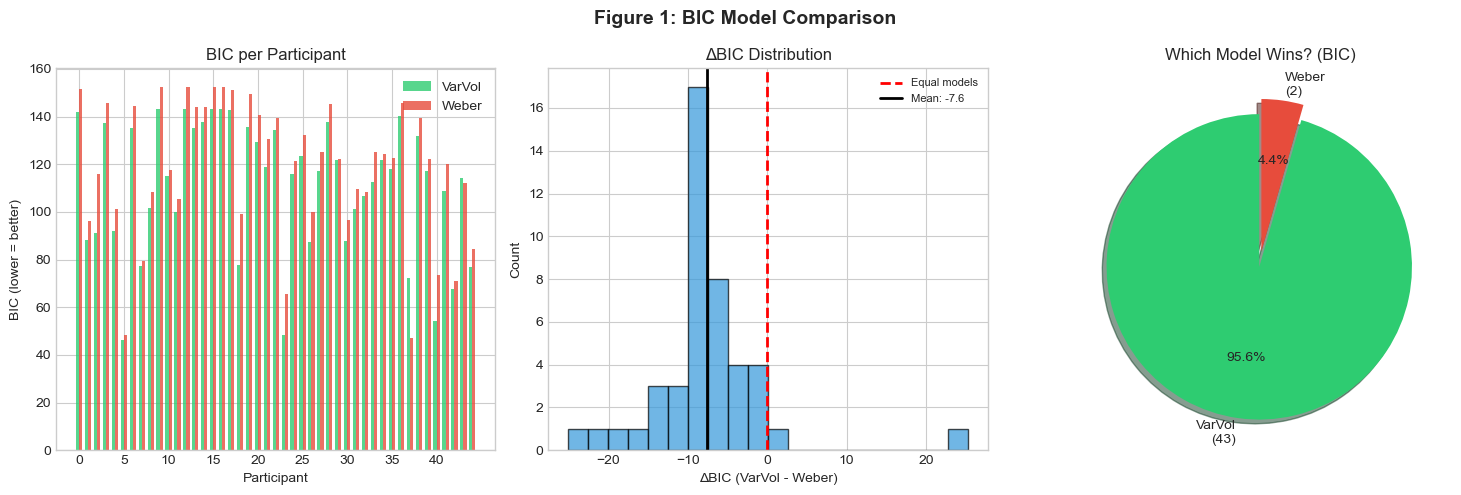

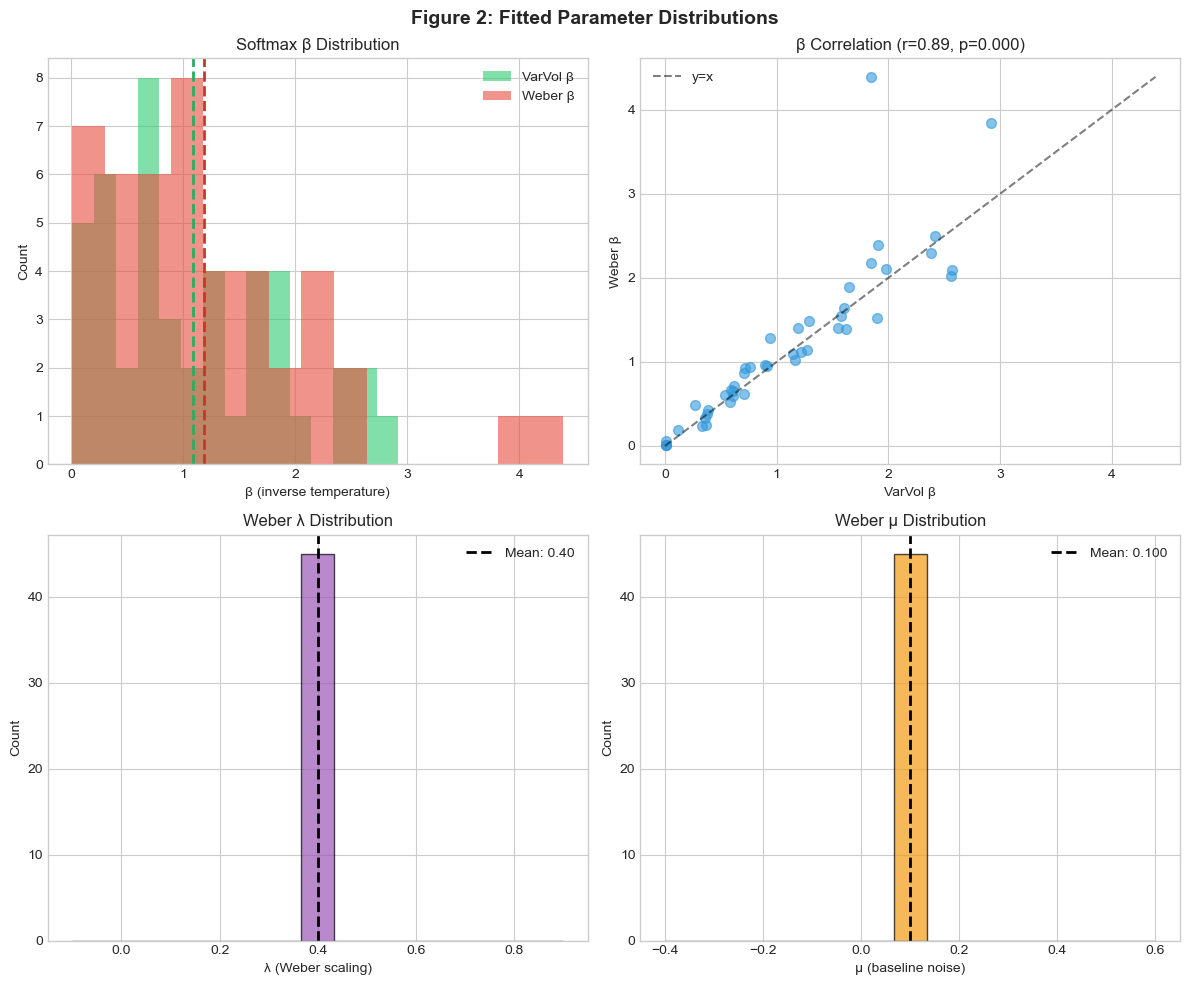

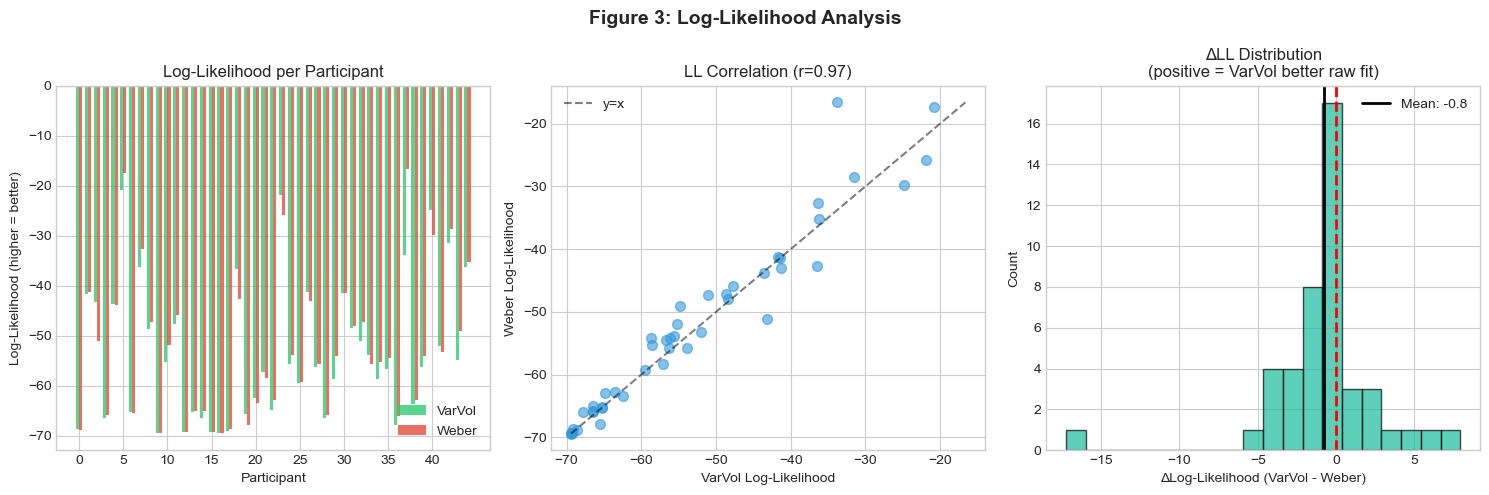


📊 Computing choice match rates with fitted parameters...


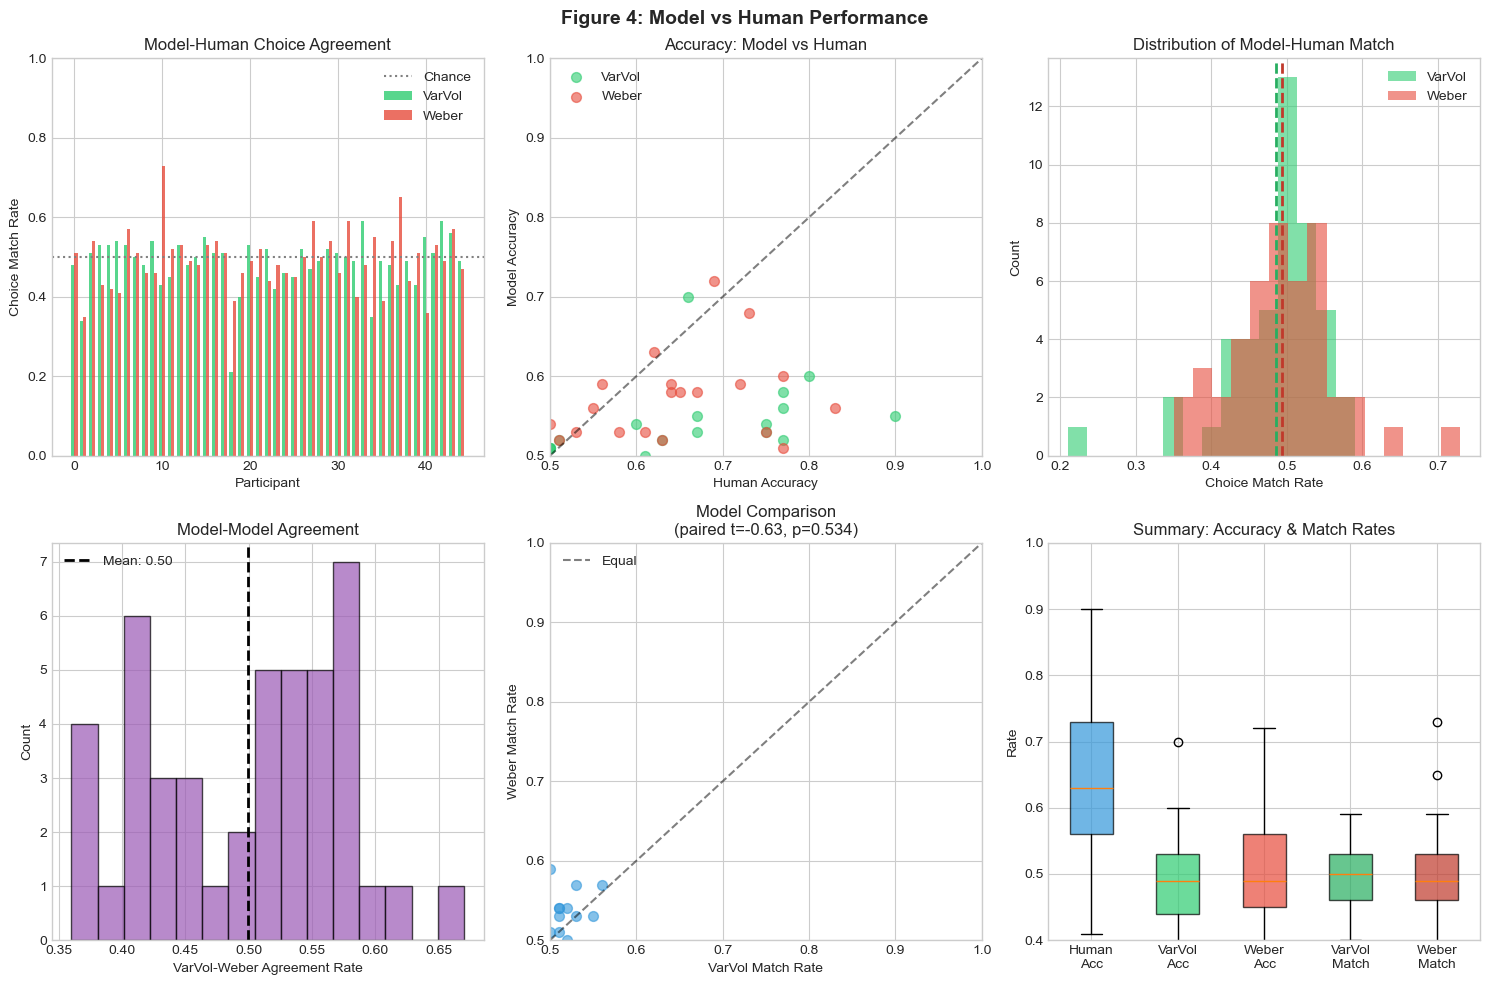


📋 FINAL SUMMARY STATISTICS

🎯 MODEL FIT (BIC - lower is better):
   VarVol Mean BIC: 110.95
   Weber Mean BIC:  118.58
   ΔBIC (VV-WB):    -7.63

🎯 CHOICE PREDICTION (higher is better):
   VarVol Match Human: 48.5%
   Weber Match Human:  49.4%

🎯 TASK ACCURACY:
   Human Accuracy:   63.7%
   VarVol Accuracy:  48.6%
   Weber Accuracy:   49.9%

🎯 MODEL AGREEMENT:
   VarVol-Weber Agreement: 50.0%

🎯 STATISTICAL TESTS:
   BIC comparison (paired t-test): t=-7.06, p=0.0000
   Choice match (paired t-test):   t=-0.63, p=0.5345

✅ All figures saved to participant_data/
   - choice_match_results.csv saved


In [ ]:
# ============================================================
# 📊 COMPREHENSIVE VISUALIZATIONS: Model Comparison
# ============================================================
# Run this AFTER the MLE fitting cell completes!
# Assumes `fitting_df` exists from the previous cell.

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Check if fitting_df exists
if 'fitting_df' not in dir():
    print("❌ fitting_df not found! Run the MLE fitting cell first.")
else:
    print("="*70)
    print("📊 GENERATING VISUALIZATIONS")
    print("="*70)
    
    # Set up style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # ============================================================
    # FIGURE 1: BIC Model Comparison (3 panels)
    # ============================================================
    fig1, axes1 = plt.subplots(1, 3, figsize=(15, 5))
    fig1.suptitle('Figure 1: BIC Model Comparison', fontsize=14, fontweight='bold')
    
    # Panel 1a: BIC per participant
    ax = axes1[0]
    n_participants = len(fitting_df)
    x = np.arange(n_participants)
    width = 0.35
    bars1 = ax.bar(x - width/2, fitting_df['varvol_bic'], width, label='VarVol', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x + width/2, fitting_df['weber_bic'], width, label='Weber', color='#e74c3c', alpha=0.8)
    ax.set_xlabel('Participant')
    ax.set_ylabel('BIC (lower = better)')
    ax.set_title('BIC per Participant')
    ax.legend()
    ax.set_xticks(x[::5])  # Show every 5th tick
    
    # Panel 1b: ΔBIC distribution
    ax = axes1[1]
    delta_bic = fitting_df['delta_bic']
    ax.hist(delta_bic, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Equal models')
    ax.axvline(delta_bic.mean(), color='black', linestyle='-', linewidth=2, 
               label=f'Mean: {delta_bic.mean():.1f}')
    ax.set_xlabel('ΔBIC (VarVol - Weber)')
    ax.set_ylabel('Count')
    ax.set_title('ΔBIC Distribution')
    ax.legend(fontsize=8)
    
    # Panel 1c: Model wins pie chart
    ax = axes1[2]
    n_varvol_wins = (fitting_df['better_model'] == 'VarVol').sum()
    n_weber_wins = (fitting_df['better_model'] == 'Weber').sum()
    colors = ['#2ecc71', '#e74c3c']
    explode = (0.05, 0.05)
    ax.pie([n_varvol_wins, n_weber_wins], 
           labels=[f'VarVol\n({n_varvol_wins})', f'Weber\n({n_weber_wins})'],
           autopct='%1.1f%%', colors=colors, explode=explode,
           shadow=True, startangle=90)
    ax.set_title('Which Model Wins? (BIC)')
    
    plt.tight_layout()
    plt.savefig('participant_data/fig1_bic_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # FIGURE 2: Fitted Parameter Distributions
    # ============================================================
    fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
    fig2.suptitle('Figure 2: Fitted Parameter Distributions', fontsize=14, fontweight='bold')
    
    # Panel 2a: β comparison (both models)
    ax = axes2[0, 0]
    ax.hist(fitting_df['varvol_beta_softmax'], bins=15, alpha=0.6, label='VarVol β', color='#2ecc71')
    ax.hist(fitting_df['weber_beta_softmax'], bins=15, alpha=0.6, label='Weber β', color='#e74c3c')
    ax.axvline(fitting_df['varvol_beta_softmax'].mean(), color='#27ae60', linestyle='--', linewidth=2)
    ax.axvline(fitting_df['weber_beta_softmax'].mean(), color='#c0392b', linestyle='--', linewidth=2)
    ax.set_xlabel('β (inverse temperature)')
    ax.set_ylabel('Count')
    ax.set_title('Softmax β Distribution')
    ax.legend()
    
    # Panel 2b: β scatter (VarVol vs Weber)
    ax = axes2[0, 1]
    ax.scatter(fitting_df['varvol_beta_softmax'], fitting_df['weber_beta_softmax'], 
               alpha=0.6, c='#3498db', s=50)
    max_beta = max(fitting_df['varvol_beta_softmax'].max(), fitting_df['weber_beta_softmax'].max())
    ax.plot([0, max_beta], [0, max_beta], 'k--', alpha=0.5, label='y=x')
    r, p = stats.pearsonr(fitting_df['varvol_beta_softmax'], fitting_df['weber_beta_softmax'])
    ax.set_xlabel('VarVol β')
    ax.set_ylabel('Weber β')
    ax.set_title(f'β Correlation (r={r:.2f}, p={p:.3f})')
    ax.legend()
    
    # Panel 2c: Weber λ distribution
    ax = axes2[1, 0]
    ax.hist(fitting_df['weber_lambdaa'], bins=15, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax.axvline(fitting_df['weber_lambdaa'].mean(), color='black', linestyle='--', linewidth=2,
               label=f'Mean: {fitting_df["weber_lambdaa"].mean():.2f}')
    ax.set_xlabel('λ (Weber scaling)')
    ax.set_ylabel('Count')
    ax.set_title('Weber λ Distribution')
    ax.legend()
    
    # Panel 2d: Weber μ distribution
    ax = axes2[1, 1]
    ax.hist(fitting_df['weber_mu'], bins=15, color='#f39c12', alpha=0.7, edgecolor='black')
    ax.axvline(fitting_df['weber_mu'].mean(), color='black', linestyle='--', linewidth=2,
               label=f'Mean: {fitting_df["weber_mu"].mean():.3f}')
    ax.set_xlabel('μ (baseline noise)')
    ax.set_ylabel('Count')
    ax.set_title('Weber μ Distribution')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('participant_data/fig2_parameters.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # FIGURE 3: Log-Likelihood Comparison
    # ============================================================
    fig3, axes3 = plt.subplots(1, 3, figsize=(15, 5))
    fig3.suptitle('Figure 3: Log-Likelihood Analysis', fontsize=14, fontweight='bold')
    
    # Panel 3a: Log-likelihood per participant
    ax = axes3[0]
    x = np.arange(n_participants)
    ax.bar(x - width/2, fitting_df['varvol_log_lik'], width, label='VarVol', color='#2ecc71', alpha=0.8)
    ax.bar(x + width/2, fitting_df['weber_log_lik'], width, label='Weber', color='#e74c3c', alpha=0.8)
    ax.set_xlabel('Participant')
    ax.set_ylabel('Log-Likelihood (higher = better)')
    ax.set_title('Log-Likelihood per Participant')
    ax.legend()
    ax.set_xticks(x[::5])
    
    # Panel 3b: LL scatter
    ax = axes3[1]
    ax.scatter(fitting_df['varvol_log_lik'], fitting_df['weber_log_lik'], 
               alpha=0.6, c='#3498db', s=50)
    min_ll = min(fitting_df['varvol_log_lik'].min(), fitting_df['weber_log_lik'].min())
    max_ll = max(fitting_df['varvol_log_lik'].max(), fitting_df['weber_log_lik'].max())
    ax.plot([min_ll, max_ll], [min_ll, max_ll], 'k--', alpha=0.5, label='y=x')
    r, p = stats.pearsonr(fitting_df['varvol_log_lik'], fitting_df['weber_log_lik'])
    ax.set_xlabel('VarVol Log-Likelihood')
    ax.set_ylabel('Weber Log-Likelihood')
    ax.set_title(f'LL Correlation (r={r:.2f})')
    ax.legend()
    
    # Panel 3c: ΔLL distribution
    ax = axes3[2]
    delta_ll = fitting_df['varvol_log_lik'] - fitting_df['weber_log_lik']
    ax.hist(delta_ll, bins=20, color='#1abc9c', alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.axvline(delta_ll.mean(), color='black', linestyle='-', linewidth=2,
               label=f'Mean: {delta_ll.mean():.1f}')
    ax.set_xlabel('ΔLog-Likelihood (VarVol - Weber)')
    ax.set_ylabel('Count')
    ax.set_title('ΔLL Distribution\n(positive = VarVol better raw fit)')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('participant_data/fig3_loglikelihood.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # FIGURE 4: Model vs Human - Choice Prediction
    # ============================================================
    print("\n📊 Computing choice match rates with fitted parameters...")
    
    from pathlib import Path
    
    DATA_DIR = Path('participant_data/extended_csvs')
    csv_files = sorted(DATA_DIR.glob('*.csv'))
    
    choice_match_results = []
    
    for i, row in fitting_df.iterrows():
        participant_id = row['participant_id']
        csv_file = DATA_DIR / f"{participant_id}.csv"
        
        if not csv_file.exists():
            continue
            
        df = pd.read_csv(csv_file)
        task, human_rewards = reconstruct_task_from_human_data(df)
        human_choices = df['userChoice'].values.astype(int)
        n_trials = len(human_choices)
        
        # Run VarVol with fitted parameters
        varvol_agent = ForwardVaryingVolatilityAgent(
            num_theta=FITTING_N_THETA,
            num_state_particles=FITTING_N_STATE,
            beta_softmax=row['varvol_beta_softmax'],
            seed=42
        )
        
        # Run Weber with fitted parameters
        weber_agent = WeberImprecisionAgent(
            num_theta=FITTING_N_THETA,
            num_state_particles=FITTING_N_STATE,
            beta_softmax=row['weber_beta_softmax'],
            lambdaa=row['weber_lambdaa'],
            mu=row['weber_mu'],
            seed=42
        )
        
        varvol_choices = []
        weber_choices = []
        varvol_probs = []
        weber_probs = []
        
        for t in range(n_trials):
            stimulus = task.stimuli[t]
            
            # VarVol choice
            vv_action, vv_probs = varvol_agent.act(stimulus)
            varvol_choices.append(vv_action)
            varvol_probs.append(vv_probs[human_choices[t]])
            varvol_agent.current_action = human_choices[t]
            varvol_agent.current_stimulus = stimulus
            varvol_agent.observe(human_rewards[t])  # Use ACTUAL human reward!
            
            # Weber choice
            wb_action, wb_probs = weber_agent.act(stimulus)
            weber_choices.append(wb_action)
            weber_probs.append(wb_probs[human_choices[t]])
            weber_agent.current_action = human_choices[t]
            weber_agent.current_stimulus = stimulus
            weber_agent.observe(human_rewards[t])  # Use ACTUAL human reward!
        
        varvol_choices = np.array(varvol_choices)
        weber_choices = np.array(weber_choices)
        
        # Compute metrics
        varvol_match = np.mean(varvol_choices == human_choices)
        weber_match = np.mean(weber_choices == human_choices)
        human_accuracy = np.mean(human_choices == task.correct_actions)
        varvol_accuracy = np.mean(varvol_choices == task.correct_actions)
        weber_accuracy = np.mean(weber_choices == task.correct_actions)
        model_agreement = np.mean(varvol_choices == weber_choices)
        
        choice_match_results.append({
            'participant_id': participant_id,
            'human_accuracy': human_accuracy,
            'varvol_accuracy': varvol_accuracy,
            'weber_accuracy': weber_accuracy,
            'varvol_match_human': varvol_match,
            'weber_match_human': weber_match,
            'model_agreement': model_agreement,
            'mean_varvol_prob': np.mean(varvol_probs),
            'mean_weber_prob': np.mean(weber_probs),
        })
    
    match_df = pd.DataFrame(choice_match_results)
    
    # Plot Figure 4
    fig4, axes4 = plt.subplots(2, 3, figsize=(15, 10))
    fig4.suptitle('Figure 4: Model vs Human Performance', fontsize=14, fontweight='bold')
    
    # Panel 4a: Choice match with human
    ax = axes4[0, 0]
    x = np.arange(len(match_df))
    ax.bar(x - width/2, match_df['varvol_match_human'], width, label='VarVol', color='#2ecc71', alpha=0.8)
    ax.bar(x + width/2, match_df['weber_match_human'], width, label='Weber', color='#e74c3c', alpha=0.8)
    ax.axhline(0.5, color='gray', linestyle=':', label='Chance')
    ax.set_xlabel('Participant')
    ax.set_ylabel('Choice Match Rate')
    ax.set_title('Model-Human Choice Agreement')
    ax.legend()
    ax.set_ylim(0, 1)
    
    # Panel 4b: Accuracy comparison
    ax = axes4[0, 1]
    ax.scatter(match_df['human_accuracy'], match_df['varvol_accuracy'], 
               alpha=0.6, label='VarVol', color='#2ecc71', s=50)
    ax.scatter(match_df['human_accuracy'], match_df['weber_accuracy'], 
               alpha=0.6, label='Weber', color='#e74c3c', s=50)
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.5)
    ax.set_xlabel('Human Accuracy')
    ax.set_ylabel('Model Accuracy')
    ax.set_title('Accuracy: Model vs Human')
    ax.legend()
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 1)
    
    # Panel 4c: Choice match distribution
    ax = axes4[0, 2]
    ax.hist(match_df['varvol_match_human'], bins=15, alpha=0.6, label='VarVol', color='#2ecc71')
    ax.hist(match_df['weber_match_human'], bins=15, alpha=0.6, label='Weber', color='#e74c3c')
    ax.axvline(match_df['varvol_match_human'].mean(), color='#27ae60', linestyle='--', linewidth=2)
    ax.axvline(match_df['weber_match_human'].mean(), color='#c0392b', linestyle='--', linewidth=2)
    ax.set_xlabel('Choice Match Rate')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Model-Human Match')
    ax.legend()
    
    # Panel 4d: Model agreement
    ax = axes4[1, 0]
    ax.hist(match_df['model_agreement'], bins=15, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax.axvline(match_df['model_agreement'].mean(), color='black', linestyle='--', linewidth=2,
               label=f'Mean: {match_df["model_agreement"].mean():.2f}')
    ax.set_xlabel('VarVol-Weber Agreement Rate')
    ax.set_ylabel('Count')
    ax.set_title('Model-Model Agreement')
    ax.legend()
    
    # Panel 4e: Paired comparison
    ax = axes4[1, 1]
    ax.scatter(match_df['varvol_match_human'], match_df['weber_match_human'], 
               alpha=0.6, c='#3498db', s=50)
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.5, label='Equal')
    t_stat, p_val = stats.ttest_rel(match_df['varvol_match_human'], match_df['weber_match_human'])
    ax.set_xlabel('VarVol Match Rate')
    ax.set_ylabel('Weber Match Rate')
    ax.set_title(f'Model Comparison\n(paired t={t_stat:.2f}, p={p_val:.3f})')
    ax.legend()
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 1)
    
    # Panel 4f: Summary boxplot
    ax = axes4[1, 2]
    data_to_plot = [match_df['human_accuracy'], match_df['varvol_accuracy'], 
                    match_df['weber_accuracy'], match_df['varvol_match_human'], 
                    match_df['weber_match_human']]
    bp = ax.boxplot(data_to_plot, tick_labels=['Human\nAcc', 'VarVol\nAcc', 'Weber\nAcc', 
                                                'VarVol\nMatch', 'Weber\nMatch'],
                    patch_artist=True)
    colors_box = ['#3498db', '#2ecc71', '#e74c3c', '#27ae60', '#c0392b']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_ylabel('Rate')
    ax.set_title('Summary: Accuracy & Match Rates')
    ax.set_ylim(0.4, 1)
    
    plt.tight_layout()
    plt.savefig('participant_data/fig4_model_vs_human.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ============================================================
    # Print Summary Statistics
    # ============================================================
    print("\n" + "="*70)
    print("📋 FINAL SUMMARY STATISTICS")
    print("="*70)
    
    print("\n🎯 MODEL FIT (BIC - lower is better):")
    print(f"   VarVol Mean BIC: {fitting_df['varvol_bic'].mean():.2f}")
    print(f"   Weber Mean BIC:  {fitting_df['weber_bic'].mean():.2f}")
    print(f"   ΔBIC (VV-WB):    {fitting_df['delta_bic'].mean():.2f}")
    
    print("\n🎯 CHOICE PREDICTION (higher is better):")
    print(f"   VarVol Match Human: {match_df['varvol_match_human'].mean():.1%}")
    print(f"   Weber Match Human:  {match_df['weber_match_human'].mean():.1%}")
    
    print("\n🎯 TASK ACCURACY:")
    print(f"   Human Accuracy:   {match_df['human_accuracy'].mean():.1%}")
    print(f"   VarVol Accuracy:  {match_df['varvol_accuracy'].mean():.1%}")
    print(f"   Weber Accuracy:   {match_df['weber_accuracy'].mean():.1%}")
    
    print("\n🎯 MODEL AGREEMENT:")
    print(f"   VarVol-Weber Agreement: {match_df['model_agreement'].mean():.1%}")
    
    # Statistical tests
    print("\n🎯 STATISTICAL TESTS:")
    t_bic, p_bic = stats.ttest_rel(fitting_df['varvol_bic'], fitting_df['weber_bic'])
    t_match, p_match = stats.ttest_rel(match_df['varvol_match_human'], match_df['weber_match_human'])
    print(f"   BIC comparison (paired t-test): t={t_bic:.2f}, p={p_bic:.4f}")
    print(f"   Choice match (paired t-test):   t={t_match:.2f}, p={p_match:.4f}")
    
    print("\n✅ All figures saved to participant_data/")
    
    # Save match results
    match_df.to_csv('participant_data/choice_match_results.csv', index=False)
    print("   - choice_match_results.csv saved")
